In [1]:
import random
import warnings
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial         import distance_matrix
from ortools.graph         import pywrapgraph
from scipy.stats           import truncnorm
from kneed                 import KneeLocator
from sklearn.neighbors     import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
%matplotlib inline

## Data Wrangling

Extracting the data from the data file.

In [2]:
#Returns a list of integer lists.
def list_lines(file_name):
    with open(file_name) as file:
        lines = file.read().splitlines()
    line_list = [[int(n) for  n in ll.split()] for ll in lines]
    return line_list

#Provides the dividing line between warehouse and order sections in the line list.
def find_wh_lines(line_list):
    wh_count = line_list[3][0]
    wh_endline = (wh_count*2)+4
    return wh_endline

#Returns a 2-d array of products(rows) by warehouses(columns).
def get_inventories(line_list):
    wh_endline = find_wh_lines(line_list)
    invs = line_list[5:wh_endline+1:2]
    supply = np.array(invs).transpose()
    return supply.astype(np.int16)

#Returns a 2-d array of products(rows) by orders(columns).
def get_orders(line_list):
    wh_endline = find_wh_lines(line_list)
    demand = np.zeros((line_list[1][0], line_list[wh_endline][0]),dtype=np.int16)
    orders = line_list[wh_endline+3::3]
    for i,ord in enumerate(orders):
        for prod in ord:
            demand[prod, i] += 1
    return demand.astype(np.int16)

#Returns the locations of Warehouses and the Orders.
def get_locs(line_list):
    wh_endline = find_wh_lines(line_list)
    wh_locs = np.array(line_list[4:wh_endline:2])
    cust_locs = np.array(line_list[wh_endline+1::3])
    return wh_locs.astype(np.int16), cust_locs.astype(np.int16)

In [3]:
line_list = list_lines('data.txt')
supply = get_inventories(line_list) #Item vs Qty present in each warehouse (shape: 400x10)
demand = get_orders(line_list) #Item vs Qty required in each order (shape: 400x1250)
warehouse_loctions, order_loctions = get_locs(line_list) #Location of warehouse and orders
distances_mtx = distance_matrix(order_loctions, warehouse_loctions) #Order vs Warehouse Distance (shape: 1250x10)
product_count, warehouse_count, order_count= supply.shape[0], supply.shape[1], demand.shape[1]
min_feedback_threshold = 3 #Hyper-parameter
max_evaluation_metric_threshold = 16 #Hyper-parameter

## Data Visualization

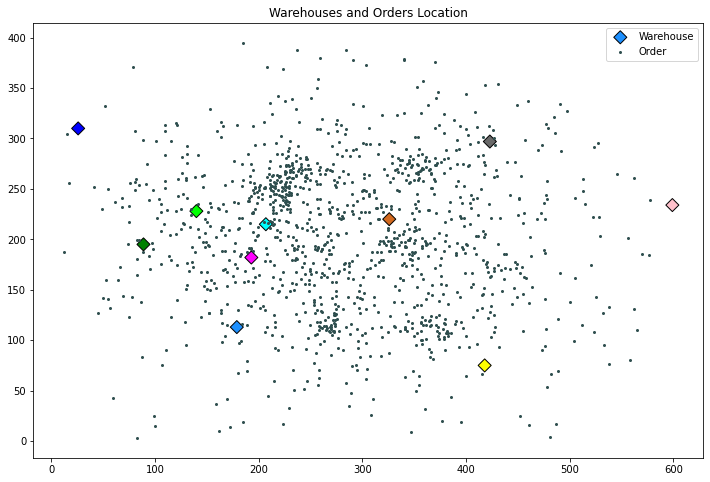

In [4]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot()
colors = ['dodgerblue','pink','green','cyan','chocolate','magenta','yellow','lime','blue','dimgrey']
wh_colors = colors[0:warehouse_count]
warehouse_points = ax.scatter(warehouse_loctions[:,1], warehouse_loctions[:,0], color=wh_colors, marker='D', edgecolors='black', s=85)
order_points = ax.scatter(order_loctions[:,1], order_loctions[:,0], s=4, color='darkslategrey')
ax.legend((warehouse_points,order_points), ("Warehouse", "Order"))
plt.title("Warehouses and Orders Location")
plt.show()

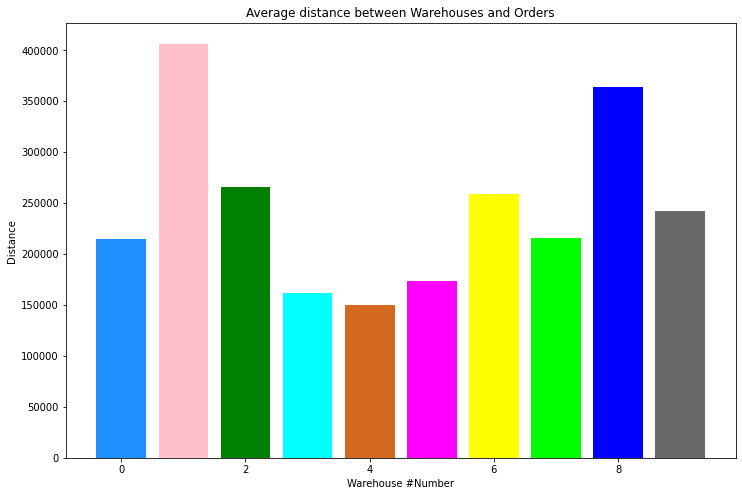

In [5]:
fig = plt.figure(figsize=(12,8))
distance_df = pd.DataFrame(distances_mtx)
avg_distance_of_warehouse_from_all_orders = distance_df.sum(axis=0).values.tolist()
plt.bar(np.arange(0,warehouse_count), avg_distance_of_warehouse_from_all_orders, color=wh_colors)
plt.xlabel("Warehouse #Number")
plt.ylabel("Distance")
plt.title("Average distance between Warehouses and Orders")
plt.show()

In [6]:
def get_random_variable_for_skewed_distribution(mean=0, sd=1, low=0, high=10):
    return truncnorm((low - mean) / sd, (high - mean) / sd, loc=mean, scale=sd)

In [7]:
class warehouse_random_variable:
    feed_back = 0
    shipping_charge = 0
    delivery_duration = 0
    
    def __init__(self, feedback_mean, shipping_charge_mean, delivery_duration_mean):
        self.feed_back         = get_random_variable_for_skewed_distribution(feedback_mean         , sd=0.5, low=1 , high=5)
        self.shipping_charge   = get_random_variable_for_skewed_distribution(shipping_charge_mean  , sd=0.5, low=0, high=100)
        self.delivery_duration = get_random_variable_for_skewed_distribution(delivery_duration_mean, sd=0.5, low=1 , high=7)

In [8]:
warehouse_0_random_variable = warehouse_random_variable(1, 95, 6)
warehouse_1_random_variable = warehouse_random_variable(4, 5,  1)
warehouse_2_random_variable = warehouse_random_variable(4, 5,  1)
warehouse_3_random_variable = warehouse_random_variable(1, 95, 6)
warehouse_4_random_variable = warehouse_random_variable(4, 5,  1)
warehouse_5_random_variable = warehouse_random_variable(1, 95, 6)
warehouse_6_random_variable = warehouse_random_variable(1, 95, 6)
warehouse_7_random_variable = warehouse_random_variable(4, 5,  1)
warehouse_8_random_variable = warehouse_random_variable(4, 5,  1)
warehouse_9_random_variable = warehouse_random_variable(1, 95, 6)

warehouses_random_variables = [warehouse_0_random_variable,
                               warehouse_1_random_variable,
                               warehouse_2_random_variable,
                               warehouse_3_random_variable,
                               warehouse_4_random_variable,
                               warehouse_5_random_variable,
                               warehouse_6_random_variable,
                               warehouse_7_random_variable,
                               warehouse_8_random_variable,
                               warehouse_9_random_variable]

def get_feedback_for_warehouse(warehouse, no_of_samples=1):
    return warehouses_random_variables[warehouse].feed_back.rvs(no_of_samples)

def get_shipping_charge_for_warehouse(warehouse, no_of_samples=1):
    return warehouses_random_variables[warehouse].shipping_charge.rvs(no_of_samples)

def get_delivery_duration_for_warehouse(warehouse, no_of_samples=1):
    return warehouses_random_variables[warehouse].delivery_duration.rvs(no_of_samples)

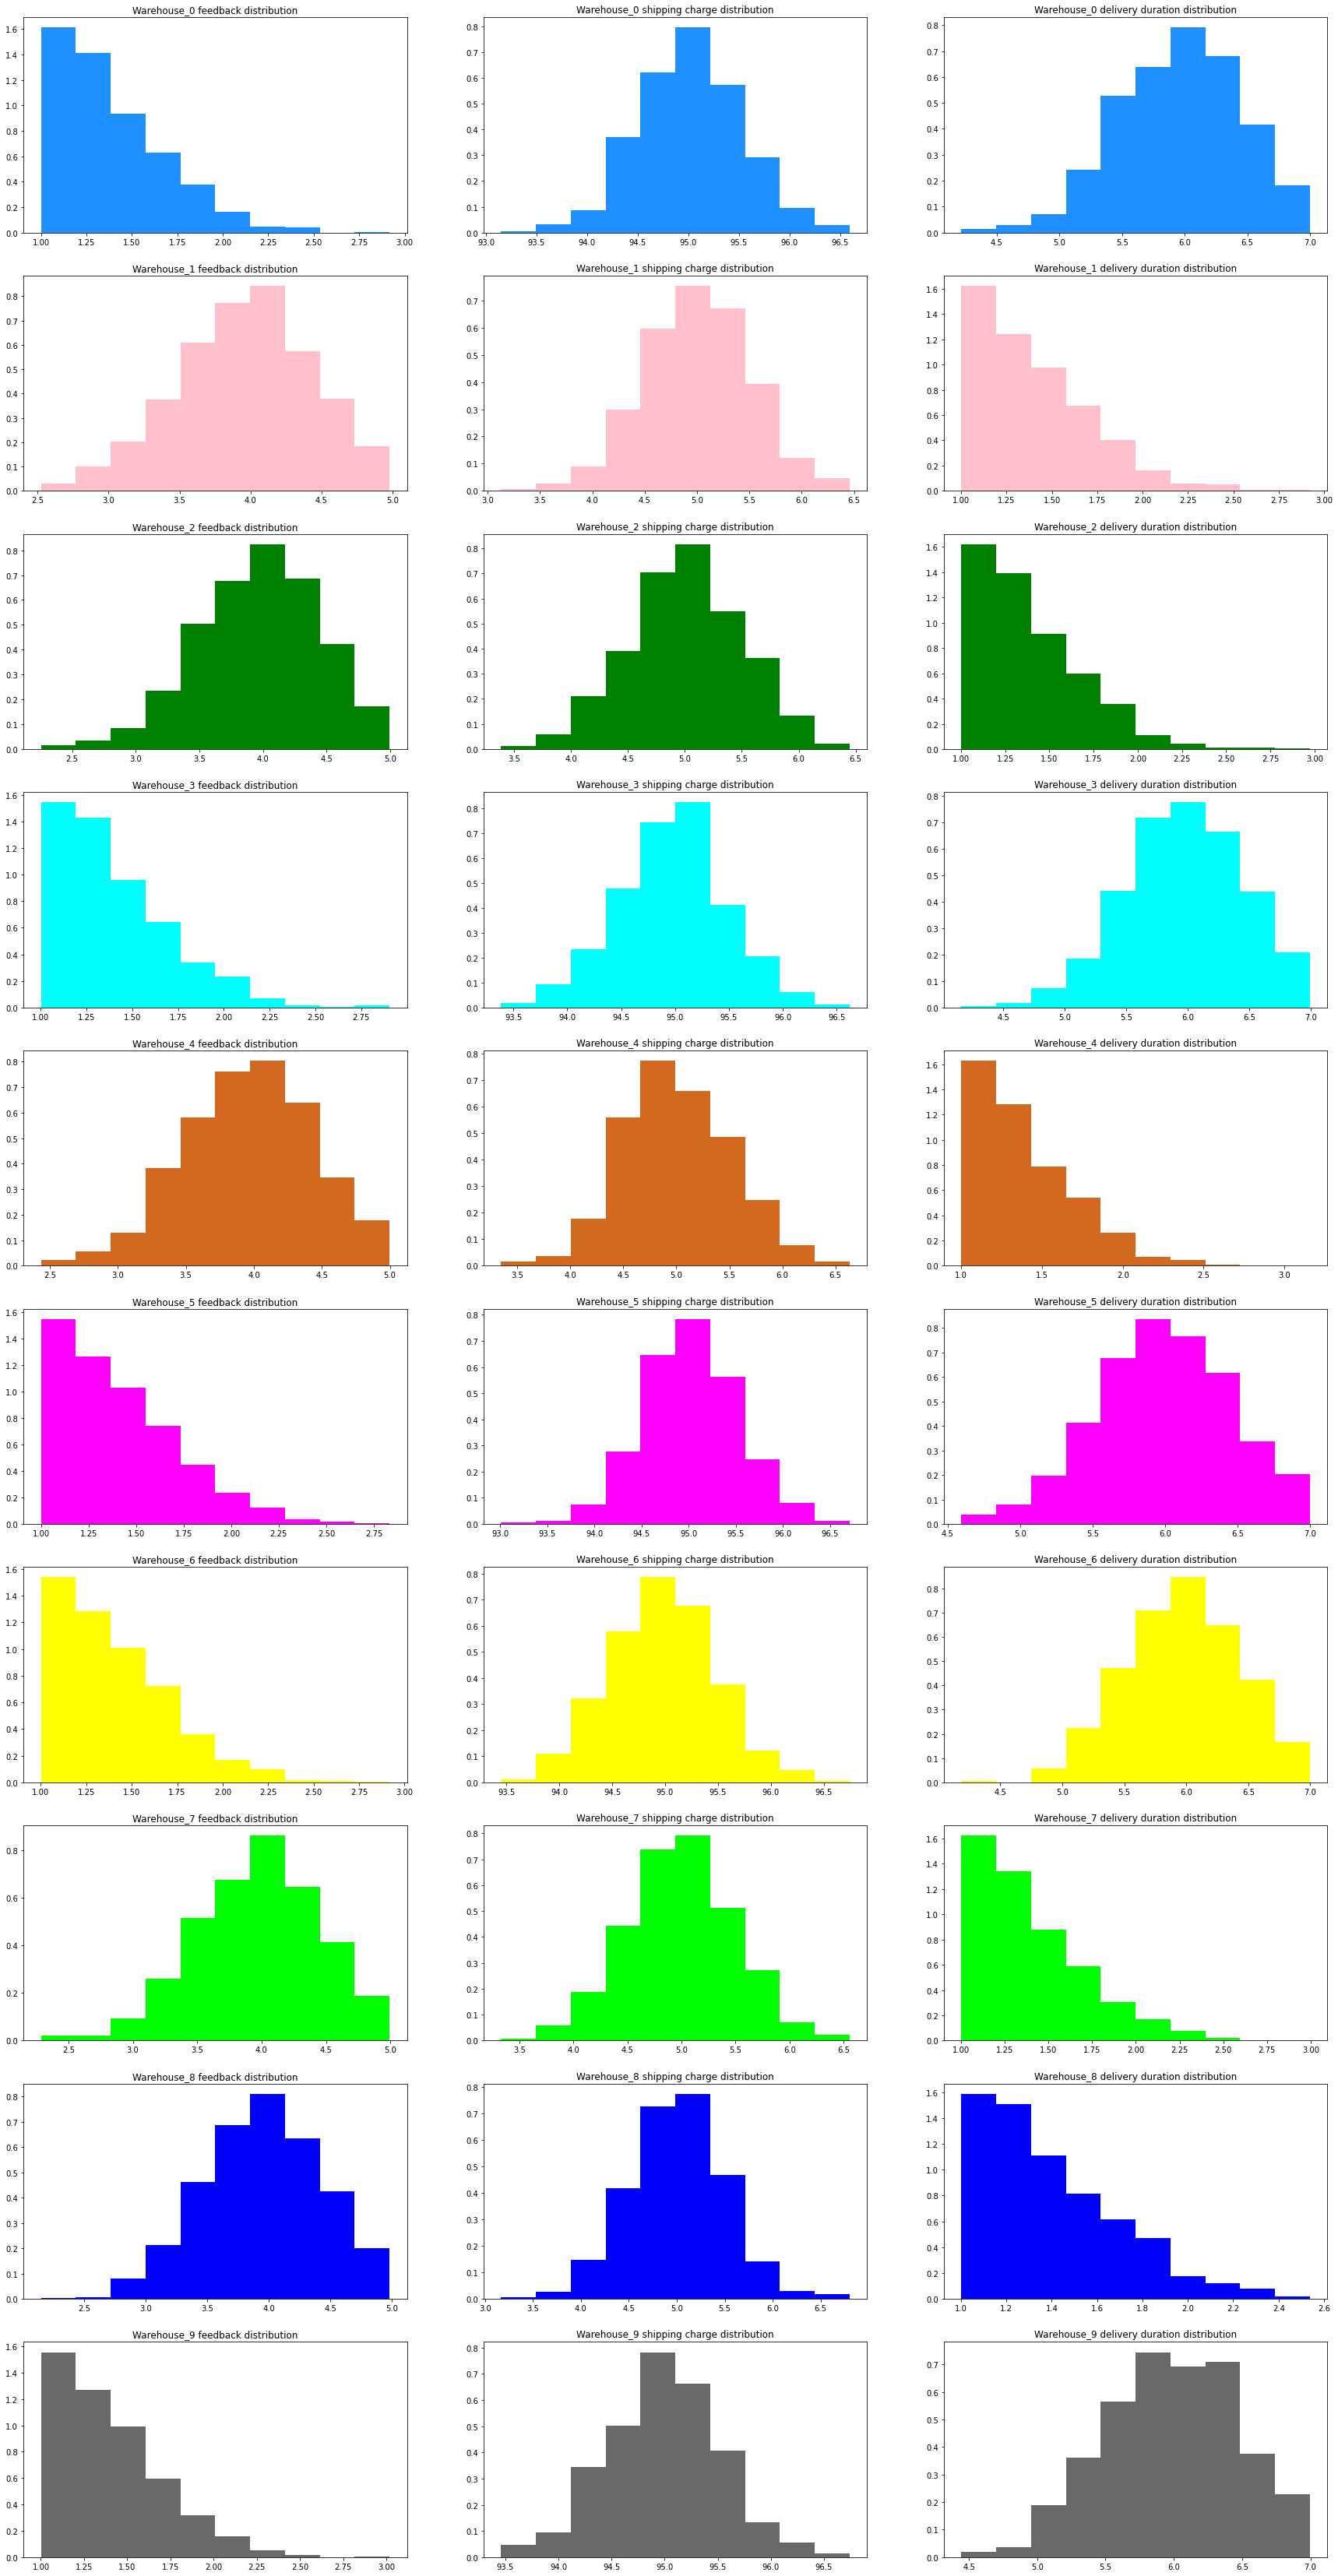

In [9]:
fig, ax = plt.subplots(warehouse_count, 3)
fig.set_figwidth(30)
fig.set_figheight(60)

for i in range(warehouse_count):
    for j in range(3):
        title = ""
        histogram_values = []
        if(j ==0):
            histogram_values = get_feedback_for_warehouse(i,1000)
            title = "Warehouse_" + str(i) + " feedback distribution"
        if(j == 1):
            histogram_values = get_shipping_charge_for_warehouse(i,1000)            
            title = "Warehouse_" + str(i) + " shipping charge distribution"
        if(j == 2):
            histogram_values = get_delivery_duration_for_warehouse(i,1000)            
            title = "Warehouse_" + str(i) + " delivery duration distribution"
            
        ax[i][j].hist(histogram_values, density=True, color=wh_colors[i])    
        ax[i][j].set_title(title)
    
plt.show()

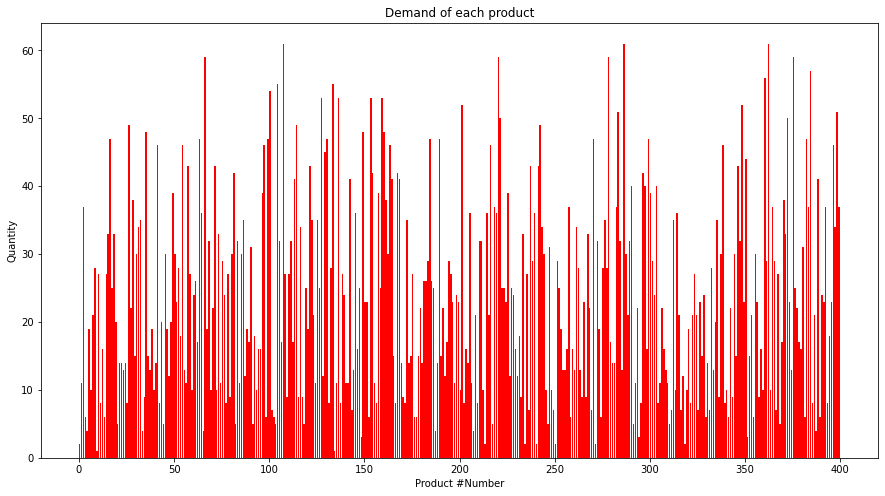

In [10]:
fig = plt.figure(figsize=(15,8))
demand_df = pd.DataFrame(demand)
demand_per_item = demand_df.sum(axis=1).values.tolist()
plt.bar(np.arange(0,product_count),demand_per_item, color='red',align='edge')
plt.xlabel("Product #Number")
plt.ylabel("Quantity")
plt.title("Demand of each product")
plt.show()

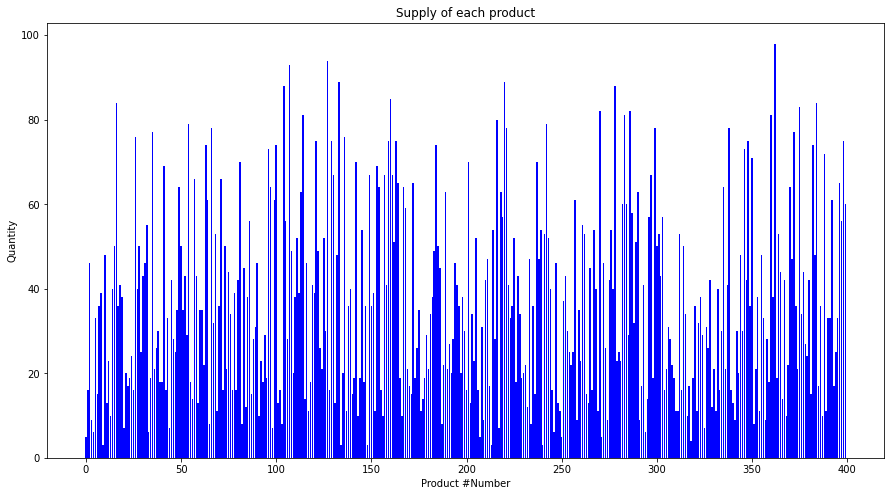

In [11]:
fig = plt.figure(figsize=(15,8))
supply_df = pd.DataFrame(supply)
supply_per_item = supply_df.sum(axis=1).values.tolist()
plt.bar(np.arange(0,product_count), supply_per_item, color='blue')
plt.xlabel("Product #Number")
plt.ylabel("Quantity")
plt.title("Supply of each product")
plt.show()

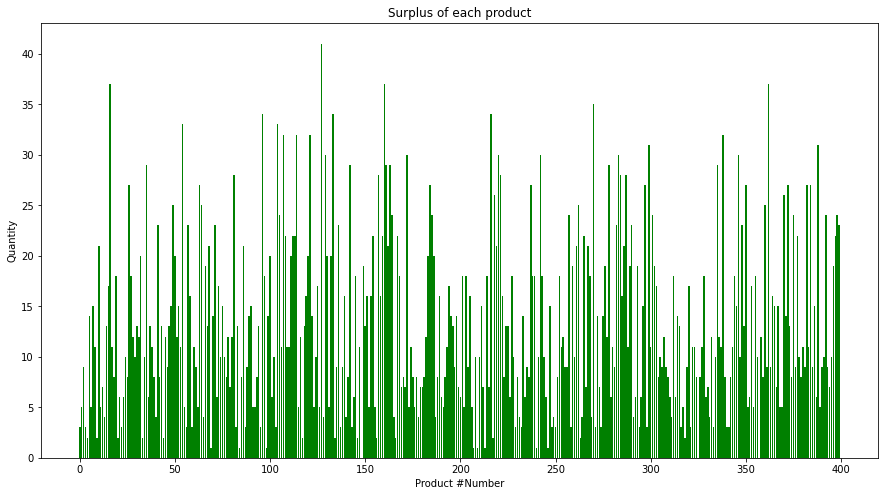

In [12]:
fig = plt.figure(figsize=(15,8))
surplus_per_item = pd.Series(supply_per_item).subtract(pd.Series(demand_per_item)).tolist()
plt.bar(np.arange(0,product_count),surplus_per_item, color='green')
plt.xlabel("Product #Number")
plt.ylabel("Quantity")
plt.title("Surplus of each product")
plt.show()

## Data Preprocessing

Feature scaling shipping_charge and delivery_duration

In [13]:
def calculate_evaluation_metrics(distances):
    
    shipping_charges = []
    delivery_durations = [] 
    
    for i in range(warehouse_count):
        shipping_charges.append(get_shipping_charge_for_warehouse(i)[0])
        delivery_durations.append(get_delivery_duration_for_warehouse(i)[0])
        
    shipping_charges_reshaped = np.reshape(np.tile(shipping_charges, order_count), (order_count, warehouse_count))
    delivery_durations_reshaped = np.reshape(np.tile(delivery_durations, order_count), (order_count, warehouse_count)) 
    
    minMaxScaler = MinMaxScaler((1,10))
    scaled_shipping_charges = minMaxScaler.fit_transform(shipping_charges_reshaped)
    scaled_delivery_durations = minMaxScaler.fit_transform(delivery_durations_reshaped)
    
    evaluation_metrics = np.multiply(scaled_shipping_charges, scaled_delivery_durations)
    return evaluation_metrics

## Model Building

Initializing penalize ratio

In [40]:
#global variables
warehouse_penalize_ratio = pd.DataFrame() #Declaring empty dataframe to hold penalize ratio
global_k_value = 0

def initialize_global_k_value():
    global global_k_value
    global_k_value = 0
    
def get_global_k_value():
    global global_k_value
    return global_k_value

def set_global_k_value(k):
    global global_k_value
    global_k_value = k
    
def initialize_warehouse_penalize_ratio():
    global warehouse_penalize_ratio 
    warehouse_penalize_ratio = pd.DataFrame(np.repeat(1.0,warehouse_count), columns=['ratio']) #Initializing the penalize ratio to 1 for all 10 warehouses

def set_warehouse_penalize_ratio(updated_warehouse_penalize_ratio):
    global warehouse_penalize_ratio 
    warehouse_penalize_ratio = updated_warehouse_penalize_ratio #Updating the penalize ratio after analysing a set of orders
    
def get_warehouse_penalize_ratio():
    global warehouse_penalize_ratio 
    return warehouse_penalize_ratio

### Feedback analyzer Model using KNearestNeighbour Algorithm
This function evaluates the performance trend of a given warehouse
by analyzing the feedback received for k past orders fulfilled by the same warehouse.

In [60]:
def regess_attribute_using_knn(warehouse_filtered_df, attribute, current_warehouse_order_assignment_row, n_neighbors):
    #weights='distance' -> Close the point, Higher the influence
    knn_regressor = KNeighborsRegressor(n_neighbors, weights='distance')
    knn_regressor.fit(warehouse_filtered_df.order_location.values.tolist(), warehouse_filtered_df[attribute].values.tolist())
    regessed_attribute_value = knn_regressor.predict([current_warehouse_order_assignment_row.order_location]) 
    return regessed_attribute_value[0]

In [62]:
def find_optimal_k_value(warehouse_filtered_df, current_warehouse_order_assignment_row):
    
    if(get_global_k_value() == 0 and warehouse_filtered_df.shape[0] < 100):
        return 5
    
    if(get_global_k_value() == 0):
        max_k_value = 25
        evaluation_metric_list = []
        feedback_list = []
        k_values = list(np.arange(5, max_k_value))
        for i in k_values:
            evaluation_metric_list.append(regess_attribute_using_knn(warehouse_filtered_df, 'evaluation_metric', current_warehouse_order_assignment_row, i))
            feedback_list.append(regess_attribute_using_knn(warehouse_filtered_df, 'feedback', current_warehouse_order_assignment_row, i))

        kneedle_for_evaluation_metric = KneeLocator(k_values, evaluation_metric_list, S=0.0, curve='concave', direction='increasing')
        kneedle_for_feedback = KneeLocator(k_values, feedback_list, S=0.0, curve='concave', direction='increasing')
            
        k_value_for_evaluation_metric = max_k_value if kneedle_for_evaluation_metric.knee == None else kneedle_for_evaluation_metric.knee
        k_value_for_feedback = max_k_value if kneedle_for_feedback.knee == None else kneedle_for_feedback.knee
        combined_k_value = int(k_value_for_evaluation_metric + k_value_for_feedback/2)
        
        if(kneedle_for_evaluation_metric.knee != None and kneedle_for_feedback.knee != None):
            kneedle_for_evaluation_metric.plot_knee()
            kneedle_for_feedback.plot_knee()
            set_global_k_value(combined_k_value)
            set_e(evaluation_metric_list)
            set_f(feedback_list)
        return combined_k_value
    
    return get_global_k_value()

In [63]:
def check_performance_of_past_k_nearest_orders(assignments):
    df = pd.DataFrame(assignments, columns=['warehouse', 'order', 'order_location', 'product', 'qty', 'evaluation_metric', 'shipping_charge', 'delivery_duration', 'feedback'])
    current_warehouse_order_assignment_row = df.iloc[-1] #Last row (recently added assignment)
    data_df = df.iloc[:-1 , :] #Removing current_warehouse_order_assignment_row from df
    #Filtering out the past orders which were fulfilled from the current warehouse under consideration
    warehouse_filtered_df = data_df.loc[data_df.warehouse == current_warehouse_order_assignment_row.warehouse] 
    
    #If the number of data points is less the required number of nearest neighbour then skip the warehouse penalization
    if warehouse_filtered_df.shape[0] < 10:
        return False
    
    k_value = find_optimal_k_value(warehouse_filtered_df, current_warehouse_order_assignment_row)
    evaluation_metric_mean = regess_attribute_using_knn(warehouse_filtered_df, 'evaluation_metric', current_warehouse_order_assignment_row, k_value)
    feedback_mean = regess_attribute_using_knn(warehouse_filtered_df, 'feedback', current_warehouse_order_assignment_row, k_value)
    
    #if the regressed feedback value from the past k nearest neighbour is less than min_feedback_threshold 
    #or the regressed evaluation_metricvalue from the past k nearest neighbour is greather than max_evaluation_metric_threshold 
    #then the current order is counted for penalization of the current warehouse
    return evaluation_metric_mean > max_evaluation_metric_threshold or feedback_mean < min_feedback_threshold

### Penalization of warehouse
The distance metric corresponding to the warehosue and orders are scaled according to the penalization ratio

In [64]:
def get_penalized_evaluation_metrics(assignments, penalize_list, distances):
    penalize_df = pd.DataFrame(penalize_list, columns=['warehouse', 'order', 'order_location', 'product', 'qty', 'evaluation_metric', 'shipping_charge', 'delivery_duration', 'feedback'])
    
    if penalize_df.shape[0] == 0:
        return distances #There are no orders counted for penalization hence then return distance as it is.
    
    df = pd.DataFrame(assignments, columns=['warehouse', 'order', 'order_location', 'product', 'qty', 'evaluation_metric', 'shipping_charge', 'delivery_duration', 'feedback'])
    last_tuple = df.iloc[-1]
    assign_df = df.loc[df['product'] == last_tuple['product']]
    
    assign_group   = assign_df.groupby('warehouse')
    penalize_group = penalize_df.groupby('warehouse')
    assign_group_count   = assign_group['order'].count()
    penalize_group_count = penalize_group['order'].count()
    zero_series = pd.Series(np.repeat(0, warehouse_count))

    padded_assign_group_count   = (zero_series + assign_group_count).fillna(1).tolist() #Filling 1 for warehouses that didn't have any order assignments
    padded_penalize_group_count = (zero_series + penalize_group_count).fillna(0).tolist() #Filling 0 for warehouses that didn't have any order counted for penalization
    ratio = np.divide(padded_penalize_group_count, padded_assign_group_count).tolist() #Dividing Order count for penalization by Total no. of orders fulfilled by the warehouse
    
    # If more than 40% of orders fulfilled by a warehouse is counted for penalization then that warehouse will be PENALIZED 
    # If less than 40% of orders fulfilled by a warehouse is counted for penalization then that warehouse will be REWARED 
    threshold_exceed_bool = pd.Series(ratio) > 0.4 # This is a hyper parameter that can be tuned as per the business needs
    
    ratio_df = pd.DataFrame(ratio, columns=['ratio'])
    new_ratio_df = get_warehouse_penalize_ratio() #Getting the existing penalize ratio
    new_ratio_df[threshold_exceed_bool]  += ratio_df #Increasing the penalize ratio for warehouse with ratio > 0.4
    #TODO: 0.4 - ratio_df
    new_ratio_df[~threshold_exceed_bool] -= ratio_df #Decreasing the penalize ratio for warehouse with ratio < 0.4 
    new_ratio_below_1_bool = new_ratio_df < 1 
    new_ratio_df[new_ratio_below_1_bool] = 1 #Capping the penalize ratio to a lowest value of 1 so that it doesn't decrease to 0 which in turn will modify the corresponding evaluation metric to 0 
    set_warehouse_penalize_ratio(new_ratio_df) #Updating the newly calculated penalize ratio
    penalize_percent_matrix = np.reshape(np.tile(new_ratio_df.ratio.values, order_count), (order_count, warehouse_count)) #shape: 1250x10
    result = np.multiply(distances, penalize_percent_matrix) #(1250x10 dot product 1250x10 = shape: 1250x10)
    return result

### Optimization Model using Google OR-tools min-cost flow solver. 
This function assigns optimal warehouse to order.
    
1260 vertices are used to construct the bipartite graph for the min-cost flow solver. They are numbered from 0 to 1259.

    Vertices numbered    0 to 1249 -> Correspond to orders
    Vertices numbered 1250 to 1259 -> Correspond to warehouses

In [65]:
def assign_warehouses_to_orders(supply, warehouse_locs, demand, order_locs, enforce_feedback_for_assignment):
    assignments = []
    penalize_list = []
    count = 0
    distances = distance_matrix(order_locs, warehouse_locs) # Order vs Warehouse Distance (shape: 1250x10)
    evaluation_metrics = calculate_evaluation_metrics(distances)
    # eg. np.repeat(np.arange(1250, 1260), 1250) :: eg [1, 1, 2, 2, 3, 3]
    start_nodes = np.repeat(np.arange(order_count, order_count + warehouse_count), order_count).tolist() 
    end_nodes   = np.tile(np.arange(0, order_count), warehouse_count).tolist() # eg. [1, 2, 3, 1, 2, 3]
    
    for i in range(product_count):  # iterate over products
        item_count = 0
        # Demand is being negated because they represent the sink. Quantity needs to flow from source to the sink
        supplies   = np.negative(demand[i]).tolist() + supply[i].tolist() # Concatinating demand and supplies
        capacities = np.tile(demand[i], warehouse_count).tolist() #Max Qty than can flow through an arc 
        penalized_evaluation_metrics = get_penalized_evaluation_metrics(assignments, penalize_list, evaluation_metrics)
        evaluation_metrics_flattened  = np.transpose(penalized_evaluation_metrics).ravel().astype(int).tolist() #Flattening the distance matrix 
        penalize_list = [] #Reinitializing it to empty list for accumating defaulting warehouses for the next item

        min_cost_flow = pywrapgraph.SimpleMinCostFlow() #min-cost solver - derterministic model

        for s in range(len(start_nodes)):
            min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[s], end_nodes[s], capacities[s], evaluation_metrics_flattened[s])
            
        for s in range(len(supplies)):
            min_cost_flow.SetNodeSupply(s, supplies[s])

        # Optimal Warehouse for Product 'i' for 'n' Orders.
        if min_cost_flow.SolveMaxFlowWithMinCost() == min_cost_flow.OPTIMAL:
            for arc in range(min_cost_flow.NumArcs()):
                if min_cost_flow.Flow(arc) > 0:
                    warehouse = min_cost_flow.Tail(arc) - order_count
                    order = min_cost_flow.Head(arc)
                    order_location = order_loctions[order].tolist()
                    product = i
                    qty = min_cost_flow.Flow(arc)
                    evaluation_metric = min_cost_flow.UnitCost(arc) #shipping_charge * delivery_duration
                    feedback = get_feedback_for_warehouse(warehouse)[0] #pick a feedback rating (Rating: 1 to 5 stars)
                    shipping_charge = get_shipping_charge_for_warehouse(warehouse)[0]
                    delivery_duration = get_delivery_duration_for_warehouse(warehouse)[0]
                    
                    assign = [warehouse, order, order_location, product, qty, evaluation_metric, shipping_charge, delivery_duration, feedback]
                    assignments.append(assign)
                    item_count += qty
                    
                    if(enforce_feedback_for_assignment and check_performance_of_past_k_nearest_orders(assignments)):
                        penalize_list.append(assign)
                        
        count += item_count
    
    print("Supply qty    : " + str(supply.sum()), "\nDemand qty    : " + str(demand.sum()), "\nFulfilled qty : " + str(count))
    return np.array(assignments, dtype=object), np.array(penalize_list, dtype=object)

In [20]:
%%time
assignments = assign_warehouses_to_orders(supply, warehouse_loctions, demand, order_loctions, False)[0]
assign_df   = pd.DataFrame(assignments,   columns=['warehouse', 'order', 'order_location', 'product', 'qty', 'evaluation_metric', 'shipping_charge', 'delivery_duration', 'feedback'])

Supply qty    : 14576 
Demand qty    : 9368 
Fulfilled qty : 9368
CPU times: user 9.44 s, sys: 78.5 ms, total: 9.51 s
Wall time: 9.59 s


Supply qty    : 14576 
Demand qty    : 9368 
Fulfilled qty : 9368
CPU times: user 3min 10s, sys: 2.82 s, total: 3min 13s
Wall time: 3min 14s


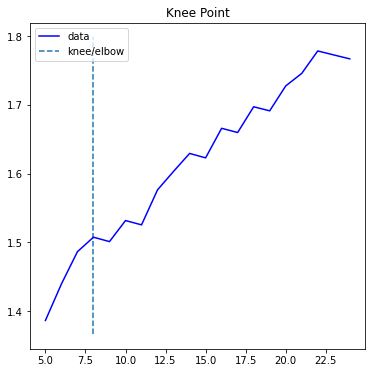

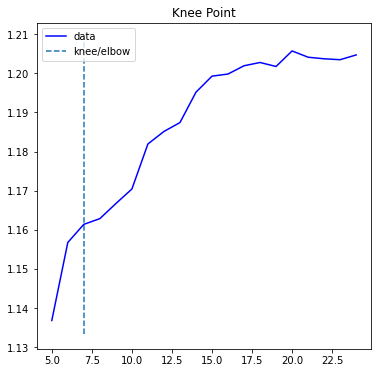

In [66]:
%%time
initialize_warehouse_penalize_ratio()
initialize_global_k_value()
feedback_enfored_assignments = assign_warehouses_to_orders(supply, warehouse_loctions, demand, order_loctions, True)[0]
feedback_enfored_assignments_df = pd.DataFrame(feedback_enfored_assignments, columns=['warehouse', 'order', 'order_location', 'product', 'qty', 'evaluation_metric', 'shipping_charge', 'delivery_duration', 'feedback'])

## Result Visualization

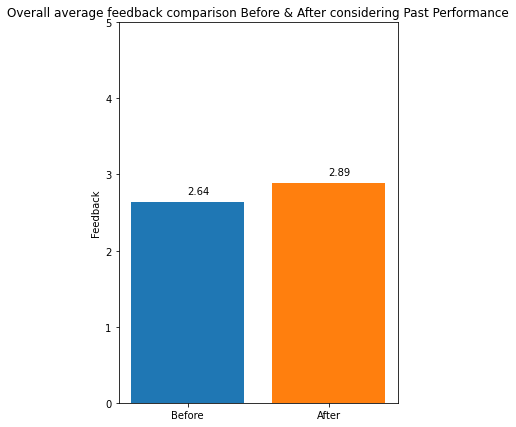

In [67]:
fig = plt.figure(figsize=(5,7))
mean_before = round(assign_df["feedback"].mean(),2)
mean_after = round(feedback_enfored_assignments_df["feedback"].mean(),2)
x_axis = ["Before", "After"]
y_axis = [mean_before, mean_after] 
for index, value in zip([0,1], y_axis):
    plt.text(index, value + 0.1, str(value))
plt.bar(x_axis, y_axis, color = ['tab:blue', 'tab:orange'])
plt.ylim(0,5)
plt.ylabel("Feedback")
plt.title("Overall average feedback comparison Before & After considering Past Performance")
plt.show()

_**Overall Average Feedback has been improved by 16%**_

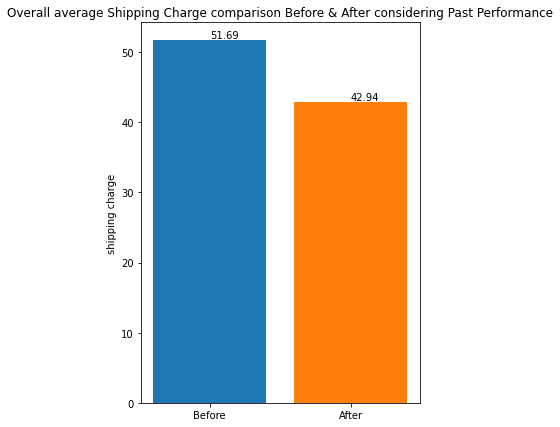

In [68]:
fig = plt.figure(figsize=(5,7))
mean_before = round(assign_df["shipping_charge"].mean(),2)
mean_after = round(feedback_enfored_assignments_df["shipping_charge"].mean(),2)
x_axis = ["Before", "After"]
y_axis = [mean_before, mean_after] 
for index, value in zip([0,1], y_axis):
    plt.text(index, value + 0.3, str(value))
plt.bar(x_axis, y_axis, color = ['tab:blue', 'tab:orange'])
plt.ylabel("shipping charge")
plt.title("Overall average Shipping Charge comparison Before & After considering Past Performance")
plt.show()

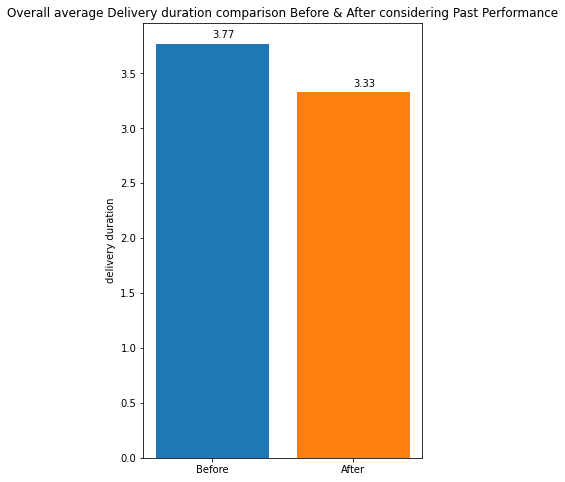

In [69]:
fig = plt.figure(figsize=(5,8))
mean_before = round(assign_df["delivery_duration"].mean(),2)
mean_after = round(feedback_enfored_assignments_df["delivery_duration"].mean(),2)
x_axis = ["Before", "After"]
y_axis = [mean_before, mean_after] 
for index, value in zip([0,1], y_axis):
    plt.text(index, value + 0.05, str(value))
plt.bar(x_axis, y_axis, color = ['tab:blue', 'tab:orange'])
plt.ylabel("delivery duration")
plt.title("Overall average Delivery duration comparison Before & After considering Past Performance")
plt.show()

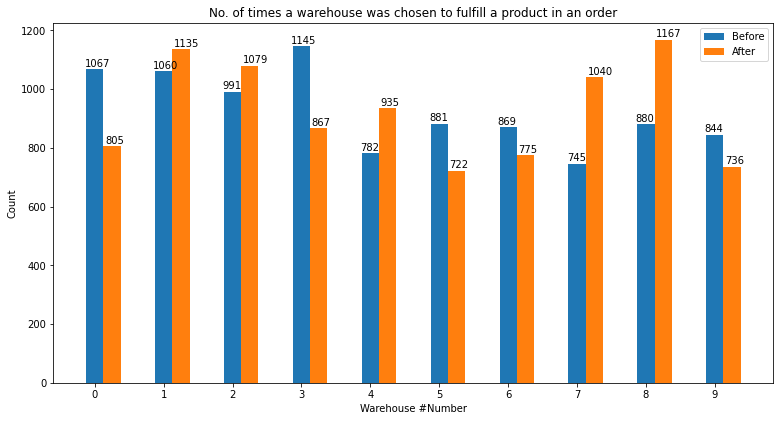

In [70]:
order_count_groupby_warehouse_before = assign_df.groupby('warehouse').count()['order']
order_count_groupby_warehouse_after  = feedback_enfored_assignments_df.groupby('warehouse').count()['order']
X = np.arange(order_count_groupby_warehouse_before.count())
gap = 10
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(X)
ax.bar(X + 0.00, order_count_groupby_warehouse_before, width = 0.25)
ax.bar(X + 0.25, order_count_groupby_warehouse_after, width = 0.25)
for index, value_before, value_after in zip(X, order_count_groupby_warehouse_before, order_count_groupby_warehouse_after):
    ax.text(index - 0.15, value_before + gap, str(value_before))
    ax.text(index + 0.15, value_after + gap, str(value_after))
ax.legend(labels=['Before', 'After'])
plt.xlabel("Warehouse #Number")
plt.ylabel("Count")
plt.title("No. of times a warehouse was chosen to fulfill a product in an order")
plt.show()

In [62]:
# TODO: Visualize warehouse - order assignments
# fig, axs = plt.subplots(warehouse_count, 2)
# fig.set_figwidth(18)
# fig.set_figheight(76)
# for i in range(0, warehouse_count):
#     for j in range(0,2):
#         axs[i, j].scatter(warehouse_loctions[:,1], warehouse_loctions[:,0], color=wh_colors, marker='D', edgecolors='black', s=85)
#         axs[i, j].scatter(order_loctions[:,1], order_loctions[:,0], s=4, color='darkslategrey')
#         axs[i, j].legend((warehouse_points,order_points), ("Warehouse", "Order"))
#         title = "Warehouse " + str(i) + " BEFORE enforcing feedback" if j % 2 != 0 else "Warehouse " + str(i) + " AFTER enforcing feedback"
#         axs[i, j].set_title(title)